In [ ]:
#pip install pyspark

In [4]:
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
import pyspark.sql.functions as F

In [5]:
spark = SparkSession.builder.getOrCreate()

In [6]:
df = spark.read.csv('insurance.csv', inferSchema=True, header=True)

In [6]:
df.show(10)

+---+------+----+--------+------+---------+--------+
|age|   sex| bmi|children|smoker|   region|expenses|
+---+------+----+--------+------+---------+--------+
| 19|female|27.9|       0|   yes|southwest|16884.92|
| 18|  male|33.8|       1|    no|southeast| 1725.55|
| 28|  male|33.0|       3|    no|southeast| 4449.46|
| 33|  male|22.7|       0|    no|northwest|21984.47|
| 32|  male|28.9|       0|    no|northwest| 3866.86|
| 31|female|25.7|       0|    no|southeast| 3756.62|
| 46|female|33.4|       1|    no|southeast| 8240.59|
| 37|female|27.7|       3|    no|northwest| 7281.51|
| 37|  male|29.8|       2|    no|northeast| 6406.41|
| 60|female|25.8|       0|    no|northwest|28923.14|
+---+------+----+--------+------+---------+--------+
only showing top 10 rows



In [8]:
df.describe().show()

+-------+------------------+------+------------------+-----------------+------+---------+------------------+
|summary|               age|   sex|               bmi|         children|smoker|   region|          expenses|
+-------+------------------+------+------------------+-----------------+------+---------+------------------+
|  count|              1338|  1338|              1338|             1338|  1338|     1338|              1338|
|   mean| 39.20702541106129|  NULL|30.665470852017993|  1.0949177877429|  NULL|     NULL|13270.422414050803|
| stddev|14.049960379216147|  NULL|  6.09838219000336|1.205492739781914|  NULL|     NULL|12110.011239706473|
|    min|                18|female|              16.0|                0|    no|northeast|           1121.87|
|    max|                64|  male|              53.1|                5|   yes|southwest|          63770.43|
+-------+------------------+------+------------------+-----------------+------+---------+------------------+



In [9]:
from pyspark.sql.functions import col,isnan, when, count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

+---+---+---+--------+------+------+--------+
|age|sex|bmi|children|smoker|region|expenses|
+---+---+---+--------+------+------+--------+
|  0|  0|  0|       0|     0|     0|       0|
+---+---+---+--------+------+------+--------+



In [5]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- expenses: double (nullable = true)



In [7]:
#StringIndexerForCategoricalValues

from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol='sex', outputCol='sex_cat')
indexed = indexer.fit(df).transform(df)

indexer = StringIndexer(inputCol='smoker',outputCol='smoker_cat')
indexed = indexer.fit(indexed).transform(indexed)

indexer = StringIndexer(inputCol='region', outputCol='region_cat')
indexed = indexer.fit(indexed).transform(indexed)

indexed.show()

+---+------+----+--------+------+---------+--------+-------+----------+----------+
|age|   sex| bmi|children|smoker|   region|expenses|sex_cat|smoker_cat|region_cat|
+---+------+----+--------+------+---------+--------+-------+----------+----------+
| 19|female|27.9|       0|   yes|southwest|16884.92|    1.0|       1.0|       2.0|
| 18|  male|33.8|       1|    no|southeast| 1725.55|    0.0|       0.0|       0.0|
| 28|  male|33.0|       3|    no|southeast| 4449.46|    0.0|       0.0|       0.0|
| 33|  male|22.7|       0|    no|northwest|21984.47|    0.0|       0.0|       1.0|
| 32|  male|28.9|       0|    no|northwest| 3866.86|    0.0|       0.0|       1.0|
| 31|female|25.7|       0|    no|southeast| 3756.62|    1.0|       0.0|       0.0|
| 46|female|33.4|       1|    no|southeast| 8240.59|    1.0|       0.0|       0.0|
| 37|female|27.7|       3|    no|northwest| 7281.51|    1.0|       0.0|       1.0|
| 37|  male|29.8|       2|    no|northeast| 6406.41|    0.0|       0.0|       3.0|
| 60

In [29]:
_df = indexed.select('age','bmi','children','expenses','sex_cat','smoker_cat','region_cat')

In [30]:
_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- expenses: double (nullable = true)
 |-- sex_cat: double (nullable = false)
 |-- smoker_cat: double (nullable = false)
 |-- region_cat: double (nullable = false)



In [31]:
#creating vector space
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=['age','bmi','children',
    'sex_cat',
    'smoker_cat','region_cat'], outputCol='feature_vectors'
)

v_df = assembler.transform(_df)

In [32]:
from pyspark.ml.feature import MinMaxScaler

mmscaler = MinMaxScaler(inputCol='feature_vectors', outputCol='feature_vectors_scaled')
s_v_df = mmscaler.fit(v_df).transform(v_df)


In [33]:
final_data = s_v_df.select('feature_vectors_scaled', 'expenses')

In [34]:
final_data.show()

+----------------------+--------+
|feature_vectors_scaled|expenses|
+----------------------+--------+
|  [0.02173913043478...|16884.92|
|  (6,[1,2],[0.47978...| 1725.55|
|  [0.21739130434782...| 4449.46|
|  [0.32608695652173...|21984.47|
|  [0.30434782608695...| 3866.86|
|  [0.28260869565217...| 3756.62|
|  [0.60869565217391...| 8240.59|
|  [0.41304347826086...| 7281.51|
|  [0.41304347826086...| 6406.41|
|  [0.91304347826086...|28923.14|
|  [0.15217391304347...| 2721.32|
|  [0.95652173913043...|27808.73|
|  [0.10869565217391...| 1826.84|
|  [0.82608695652173...|11090.72|
|  [0.19565217391304...|39611.76|
|  [0.02173913043478...| 1837.24|
|  [0.73913043478260...|10797.34|
|  [0.10869565217391...| 2395.17|
|  [0.82608695652173...|10602.39|
|  [0.26086956521739...|36837.47|
+----------------------+--------+
only showing top 20 rows



In [35]:
#splitting data
train_data, test_data = final_data.randomSplit([.7,.3])

In [36]:
train_data.describe().show()

+-------+------------------+
|summary|          expenses|
+-------+------------------+
|  count|               950|
|   mean|12920.168389473683|
| stddev|11792.784136214848|
|    min|           1121.87|
|    max|          63770.43|
+-------+------------------+



In [38]:
test_data.describe().show()

+-------+------------------+
|summary|          expenses|
+-------+------------------+
|  count|               388|
|   mean|14128.003144329909|
| stddev|12829.142081085165|
|    min|           1131.51|
|    max|          62592.87|
+-------+------------------+



In [40]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol='feature_vectors_scaled', labelCol='expenses')
model = lr.fit(train_data)

In [44]:
model_eval = model.evaluate(train_data)
print(f'r2 error: {model_eval.r2}')
print(f'MeanSquaredError: {model_eval.meanSquaredError}')
print(f'MeanAbsoluteError: {model_eval.meanAbsoluteError}')

r2 error: 0.7501585432839012
MeanSquaredError: 34708816.749139614
MeanAbsoluteError: 4068.546699043424


In [48]:
#making prediction

pred = model.transform(test_data.select('feature_vectors_scaled'))
pred.show()

+----------------------+-------------------+
|feature_vectors_scaled|         prediction|
+----------------------+-------------------+
|  (6,[0,1],[0.10869...| 1533.7386151176393|
|  (6,[0,1],[0.10869...|  3562.466245358181|
|  (6,[0,1],[0.34782...| 6922.8405470956695|
|  (6,[0,1],[0.47826...| 10959.859081941087|
|  (6,[0,1],[0.5,0.6...| 10751.363009310824|
|  (6,[0,1],[0.69565...|  8076.710435543839|
|  (6,[0,1],[0.73913...| 11517.626570740738|
|  (6,[0,1],[0.76086...| 10244.879937984291|
|  (6,[0,1],[0.82608...| 12645.854250452348|
|  (6,[0,1],[0.86956...|   18048.9823558819|
|  (6,[0,1],[0.91304...| 10780.877229809064|
|  (6,[0,1],[0.97826...| 16806.955012706934|
|  (6,[1],[0.3800539...| 1445.4527581348725|
|  (6,[1],[0.4770889...| 2642.7346382768314|
|  (6,[1],[0.6765498...|  5103.814058568634|
|  (6,[1,2],[0.15633...| -292.3399604158353|
|  (6,[1,2],[0.47978...|  3187.296054169064|
|  (6,[1,3],[0.12938...|-1403.2504995979077|
|  (6,[1,3],[0.28840...|  558.9614706347456|
|  (6,[1,3

In [51]:
pred = pred.toPandas()
actual = test_data.toPandas()

In [55]:
pred['actual'] =  actual['expenses']

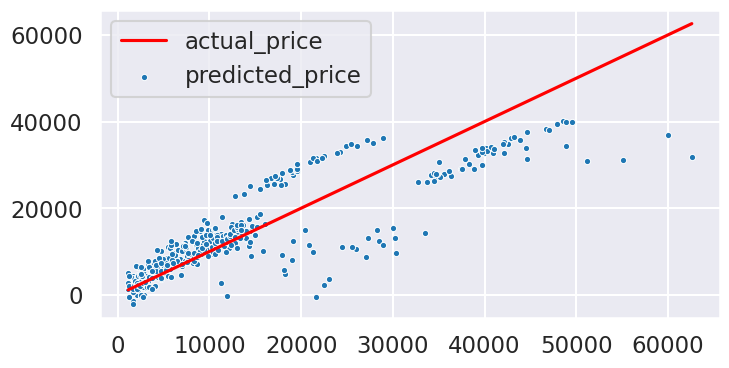

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize = (8,4))
sns.set_style('darkgrid')
sns.set_context('talk')

sns.lineplot(x = 'expenses', y = 'expenses', data = actual, color = 'red', label = 'actual_price')
sns.scatterplot(x = 'actual', y = 'prediction', data = pred, marker = '.',label = 'predicted_price')
plt.legend()
plt.xlabel('')
plt.ylabel('')

plt.show()

Ref:
https://www.projectpro.io/hadoop-tutorial/pyspark-machine-learning-tutorial

https://www.analyticsvidhya.com/blog/2022/09/machine-learning-pipeline-in-pyspark/
